# Data Preprocessing

Intro to BERT and fine-tuning for sentiment analysis:
- https://machinelearningmastery.com/a-brief-introduction-to-bert/
- https://machinelearningmastery.com/a-complete-introduction-to-using-bert-models/
- https://skimai.com/fine-tuning-bert-for-sentiment-analysis/
- https://mccormickml.com/2019/07/22/BERT-fine-tuning/

## Load the libraries and data

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ast
import re
import torch

from transformers import BertTokenizer
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("data/cryptonews.csv")
df.shape

(31037, 7)

In [28]:
# Display a set of 10 random rows from the dataset.
df.sample(10)

,date,sentiment,source,subject,text,title,url
9021,2023-06-22 13:37:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,ChatGPT thinks there are seven factors that co...,After $30K: 7 Things for Bitcoin’s Price to Re...,https://cryptopotato.com/after-30k-7-things-fo...
16242,2023-01-07 10:52:57,"{'class': 'positive', 'polarity': 0.12, 'subje...",CoinTelegraph,bitcoin,Bets are increasing on a push higher for Bitco...,Bitcoin price nears 3-week high as trader says...,https://cointelegraph.com/news/bitcoin-price-n...
12452,2023-04-05 20:38:00,"{'class': 'positive', 'polarity': 0.29, 'subje...",CryptoNews,altcoin,The cryptocurrency market remains strong and u...,"Best Crypto to Buy Now 5 April \x93 RPL, LDO, OP",https://cryptonews.com/news/best-crypto-buy-no...
29243,2022-02-17 15:19:00,"{'class': 'negative', 'polarity': -0.12, 'subj...",CryptoNews,bitcoin,'The Central Bank wants to ban crypto <...> Th...,Late Drama Threatens to Disrupt Russian Crypto...,https://cryptonews.com/news/late-drama-threate...
26599,2022-04-22 13:01:11,"{'class': 'positive', 'polarity': 0.02, 'subje...",CoinTelegraph,blockchain,The industry may have 10 years or less to devi...,Quantum computing to run economic models on cr...,https://cointelegraph.com/news/quantum-computi...
25176,2022-05-26 10:26:00,"{'class': 'negative', 'polarity': -0.19, 'subj...",CoinTelegraph,blockchain,"Michael Miebach, CEO of Mastercard told an aud...",SWIFT probably won't exist in 5 years: Masterc...,https://cointelegraph.com/news/swift-probably-...
9838,2023-06-05 12:45:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,altcoin,Atomic Wallet has not yet released the specifi...,Over $35 Million Reportely Stolen From Atomic ...,https://cryptopotato.com/over-35-million-repor...
22207,2022-08-08 10:40:32,"{'class': 'positive', 'polarity': 0.6, 'subjec...",CoinTelegraph,bitcoin,The Google trends data for the popular search ...,Nigeria becomes the most crypto-obsessed natio...,https://cointelegraph.com/news/nigeria-becomes...
26305,2022-04-29 15:10:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,The central bank of Switzerland may be mulling...,Swiss National Bank Chairman: Bitcoin Does Not...,https://cryptopotato.com/swiss-national-bank-c...
19095,2022-10-26 16:56:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,altcoin,Meta recently revealed its partnership with Fr...,Meta Partners with Fashion Company L'OrÃ©al to...,https://cryptonews.com/news/meta-partners-with...


## Transforming data 

### Extract sentiment labels from dictionary string

In [39]:
def extract_sentiment_components(sentiment_str):
    try:
        # Check if the sentiment is already a dictionary
        if isinstance(sentiment_str, dict):
            return {
                'sentiment_class': sentiment_str.get('class'),
                'polarity': sentiment_str.get('polarity'),
                'subjectivity': sentiment_str.get('subjectivity')
            }
            
        # Otherwise, parse it as a string representation of a dictionary
        sentiment_dict = ast.literal_eval(sentiment_str)
        return {
            'sentiment_class': sentiment_dict.get('class'),
            'polarity': sentiment_dict.get('polarity'),
            'subjectivity': sentiment_dict.get('subjectivity')
        }
    except Exception as e:
        print(f"Error parsing sentiment: {sentiment_str}")
        print(f"Error message: {e}")
        return {'sentiment_class': None, 'polarity': None, 'subjectivity': None}

# Apply the function to create new columns
sentiment_components = df['sentiment'].apply(extract_sentiment_components)

# Extract the components into separate columns
df['sentiment_class'] = sentiment_components.apply(lambda x: x['sentiment_class'])
df['polarity'] = sentiment_components.apply(lambda x: x['polarity'])
df['subjectivity'] = sentiment_components.apply(lambda x: x['subjectivity'])

# Optionally drop the original sentiment columns
# df.drop(columns=['sentiment', 'sentiment_dict'], inplace=True, errors='ignore')

df[['sentiment', 'sentiment_class', 'polarity', 'subjectivity']].head()

,sentiment,sentiment_class,polarity,subjectivity
0,"{'class': 'negative', 'polarity': -0.1, 'subje...",negative,-0.10,0.60
1,"{'class': 'neutral', 'polarity': 0.0, 'subject...",neutral,0.00,0.00
2,"{'class': 'positive', 'polarity': 0.05, 'subje...",positive,0.05,0.05
3,"{'class': 'positive', 'polarity': 0.5, 'subjec...",positive,0.50,0.90
4,"{'class': 'neutral', 'polarity': 0.0, 'subject...",neutral,0.00,0.00


### Map sentiment classes to numeric labels

In [40]:
label2id = {"negative": 0, "neutral": 1, "positive": 2}
df['sentiment_class'] = df['sentiment_class'].str.lower().str.strip().map(label2id)

df[['sentiment_class']].head()

,sentiment_class
0,0
1,1
2,2
3,2
4,1


### Convert publication timestamp to datetime format

In [30]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['date'].describe()

count                            31035
mean     2023-01-12 21:01:43.553665280
min                2021-10-12 20:00:00
25%         2022-07-10 21:18:26.500000
50%                2023-01-24 17:00:04
75%                2023-07-18 11:34:35
max                2023-12-19 06:40:41
Name: date, dtype: object

### Visualise distribution of sentiment classes 

In [31]:
sentiment_counts = df['sentiment_class'].value_counts()

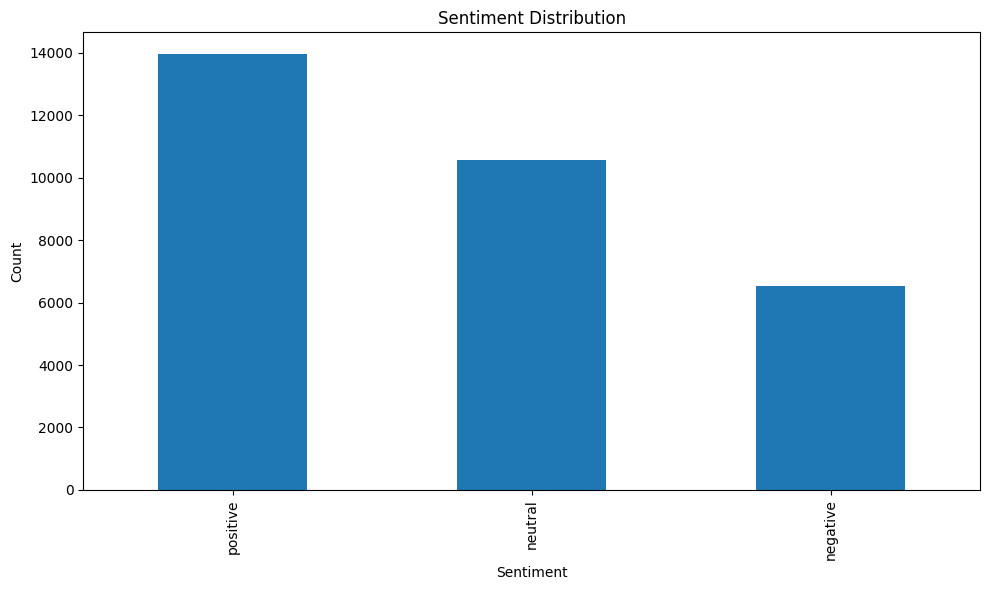

In [32]:
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Combine headline and content

In [42]:
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df.head()

,date,sentiment,source,subject,text,title,url,sentiment_class,polarity,subjectivity,clean_text,full_text
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...,0,-0.10,0.60,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...,1,0.00,0.00,In an exclusive interview with CryptoNews Manh...,Indian Government is Actively Collaborating Wi...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...,2,0.05,0.05,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...,2,0.50,0.90,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...,1,0.00,0.00,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...


## Cleaning text data

In [43]:
def clean_text(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove special characters
        text = re.sub(r'[^\w\s]', ' ', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    return ""

df['clean_text'] = df['text'].apply(clean_text)
df.head()

,date,sentiment,source,subject,text,title,url,sentiment_class,polarity,subjectivity,clean_text,full_text
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...,0,-0.10,0.60,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...,1,0.00,0.00,In an exclusive interview with CryptoNews Manh...,Indian Government is Actively Collaborating Wi...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...,2,0.05,0.05,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...,2,0.50,0.90,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...,1,0.00,0.00,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...


## Other

In [25]:
# le = LabelEncoder()
# df["label"] = le.fit_transform(df['label'])

tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
tokenizer_kwargs = {}
tokens = tokenizer.tokenize(df["text"].iloc[0], **tokenizer_kwargs)

tokens

['gray',
 '##sca',
 '##le',
 'ceo',
 'michael',
 'son',
 '##nen',
 '##sh',
 '##ein',
 'believes',
 'the',
 'sec',
 'needs',
 'to',
 'approve',
 'spot',
 'bit',
 '##co',
 '##in',
 'exchange',
 '-',
 'traded',
 'funds',
 '(',
 'et',
 '##fs',
 ')',
 'simultaneously',
 '.']